In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime, timedelta

In [2]:
# Loading data
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')


In [3]:
# Initial exploration
print(customers.head())
print(transactions.head())
print(engagement.head())
print(marketing.head())

   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

In [7]:
# DATA CLEANING AND PREPARATION

# Rename these columns in the engagement DataFrame to avoid duplicates
engagement = engagement.rename(columns={
    'number_of_site_visits': 'engagement_site_visits',
    'number_of_emails_opened': 'engagement_emails_opened',
    'number_of_clicks': 'engagement_clicks'
})

# Converting dates to DateTime
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Imputing missing values
customers['age'].fillna(customers['age'].median(), inplace=True)
customers['gender'].fillna('Unknown', inplace=True)
imputer = KNNImputer(n_neighbors=5)
customers[['age']] = imputer.fit_transform(customers[['age']])

# Calculating Months from Join Date to Last Purchase Date
customers['months_active'] = (customers['last_purchase_date'] - customers['join_date']).dt.days // 30
customers['months_active'].replace(0, 1, inplace=True)

# Feature Engineering
# Assuming you want to calculate spend by day 7 of their journey
day_7_date = customers['join_date'] + timedelta(days=7)

def calculate_day_7_spend(row, day_7_date_dict):
    customer_id = row['customer_id']
    if customer_id in day_7_date_dict:
        day_7 = day_7_date_dict[customer_id]
        if row['transaction_date'] <= day_7:
            return row['transaction_amount']
    return 0

day_7_date_dict = customers.set_index('customer_id')['join_date'].to_dict()
day_7_date_dict = {k: v + timedelta(days=7) for k, v in day_7_date_dict.items()}
transactions['day_7_spend'] = transactions.apply(calculate_day_7_spend, axis=1, day_7_date_dict=day_7_date_dict)
day_7_spend = transactions.groupby('customer_id')['day_7_spend'].sum()
customers['day_7_spend'] = customers['customer_id'].map(day_7_spend).fillna(0)

# RFM analysis
current_date = datetime.now()
customers['recency'] = (current_date - customers['last_purchase_date']).dt.days

# Calculate Frequency
frequency = transactions.groupby('customer_id').size()
customers['frequency'] = customers['customer_id'].map(frequency).fillna(0)

# Additional feature engineering as needed
# Use the correct column names for the calculation
customers['click_per_transaction'] = engagement['engagement_clicks'] / customers['frequency']
customers['visit_per_transaction'] = engagement['engagement_site_visits'] / customers['frequency']
customers['email_per_transaction'] = engagement['engagement_emails_opened'] / customers['frequency']

# Calculating response rate
positive_responses = marketing[marketing['response'] == 'Yes'].groupby('customer_id').size()
total_responses = marketing.groupby('customer_id').size()
customers['response_rate'] = customers['customer_id'].map(positive_responses) / customers['customer_id'].map(total_responses)
customers['response_rate'].fillna(0, inplace=True)

# Add additional feature engineering based on feedback
customers['other_features'] = customers[['click_per_transaction', 'visit_per_transaction', 'email_per_transaction']].sum(axis=1)

# Merging with Engagement Data (with renamed columns)
customers = customers.merge(engagement, on='customer_id', how='left')
customers.fillna(0, inplace=True)


C:\Users\aayre\AppData\Local\Temp\ipykernel_7300\2967846624.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['age'].fillna(customers['age'].median(), inplace=True)
C:\Users\aayre\AppData\Local\Temp\ipykernel_7300\2967846624.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

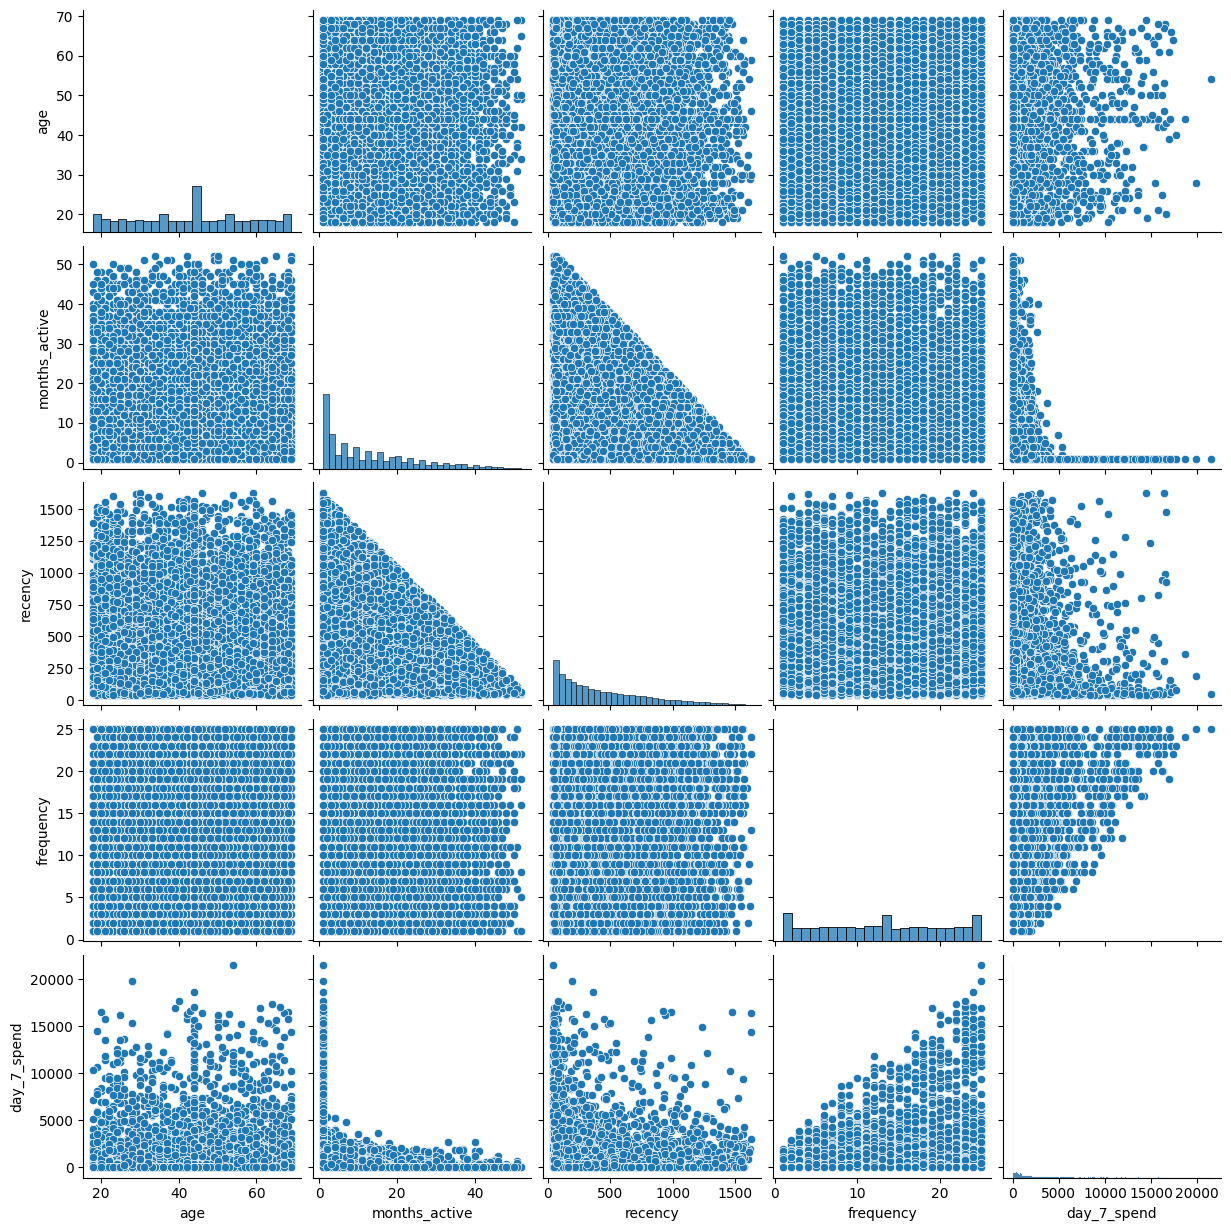

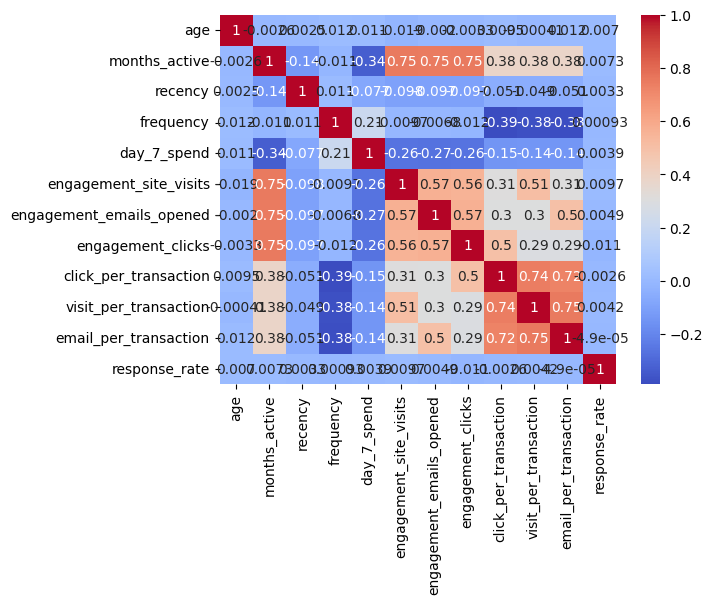

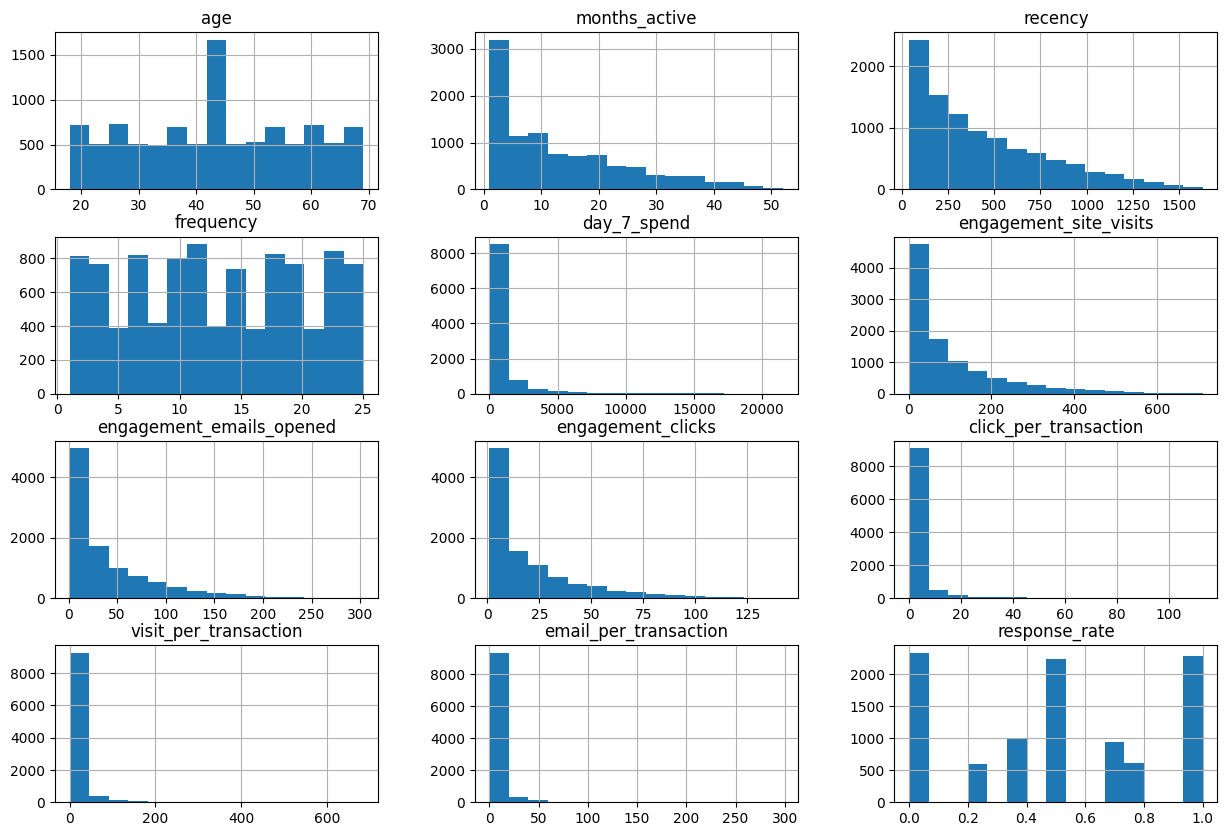

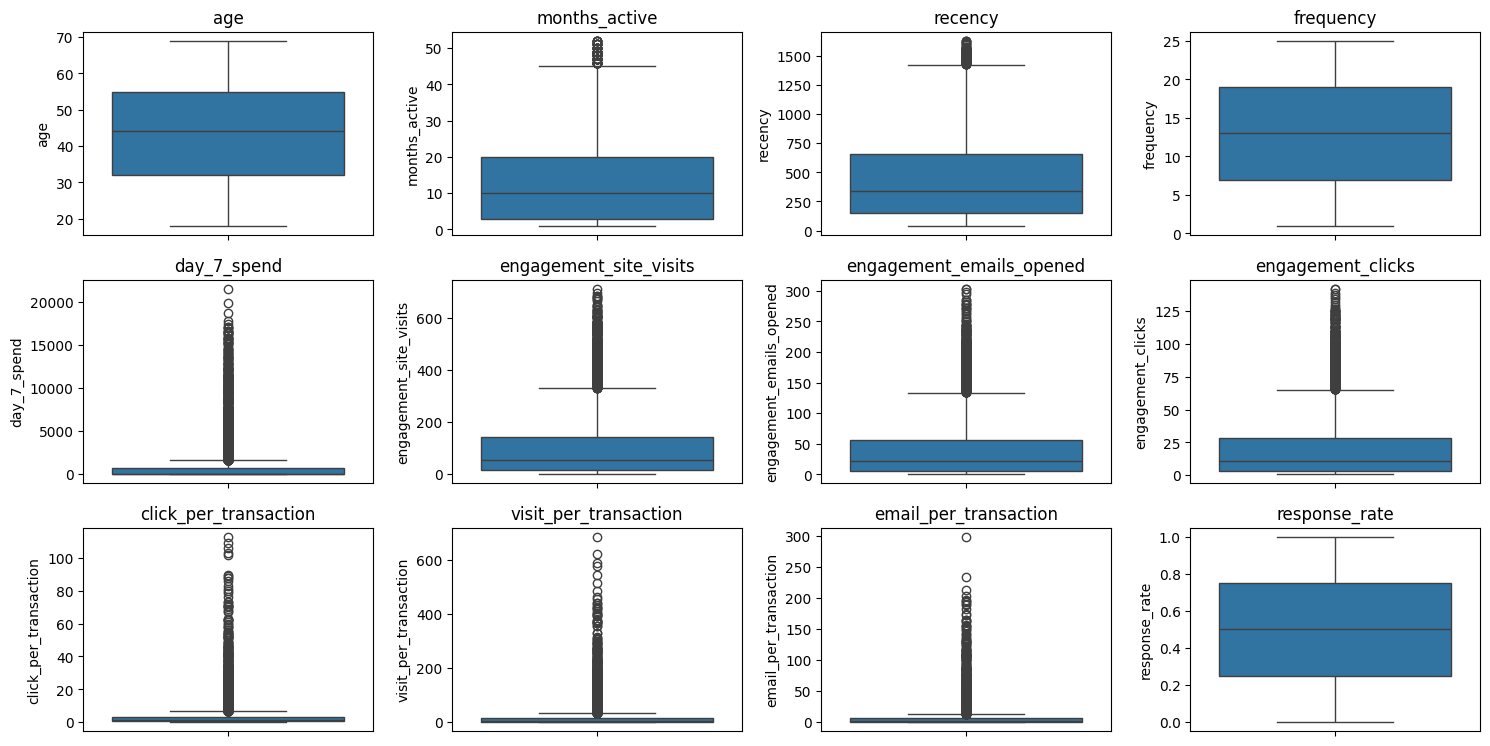

VIF values:
                 feature       VIF
0                    age  5.480128
1          months_active  2.793538
2                recency  2.361766
3              frequency  4.302005
4  click_per_transaction  3.222395
5  visit_per_transaction  3.436567
6  email_per_transaction  3.215297
7          response_rate  2.645961
8        click_per_visit  1.094246


C:\Users\aayre\AppData\Local\Temp\ipykernel_7300\1641541580.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['click_per_visit'].fillna(0, inplace=True)  # Replace NaN with 0 or impute
C:\Users\aayre\AppData\Local\Temp\ipykernel_7300\1641541580.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

NameError: name 'LinearRegression' is not defined

In [8]:
# EXPLORATORY DATA ANALYSIS (EDA)

# Pairplot for initial exploration
sns.pairplot(customers[['age', 'months_active', 'recency', 'frequency', 'day_7_spend']])
plt.show()

# Correlation matrix
numeric_cols = customers[['age', 'months_active', 'recency', 'frequency', 'day_7_spend', 'engagement_site_visits', 'engagement_emails_opened', 'engagement_clicks', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate']]
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Histograms for numeric columns
numeric_cols.hist(bins=15, figsize=(15, 10))
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols.columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=numeric_cols[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Handling Multicollinearity

# Feature Engineering: Create new feature based on relationship between clicks, visits, and emails
customers['click_per_visit'] = customers['click_per_transaction'] / customers['visit_per_transaction']

# Ensure there are no infinite or NaN values
customers['click_per_visit'] = customers['click_per_visit'].replace([float('inf'), -float('inf')], float('nan'))
customers['click_per_visit'].fillna(0, inplace=True)  # Replace NaN with 0 or impute

# Select features for VIF calculation
X = customers[['age', 'months_active', 'recency', 'frequency', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate', 'click_per_visit']]

# Check for remaining NaN or inf values
nan_columns = X.columns[X.isna().any()].tolist()
if nan_columns:
    print(f"Warning: NaN values found in columns: {nan_columns}")
    
inf_columns = X.columns[np.isinf(X).any()].tolist()
if inf_columns:
    print(f"Warning: Inf values found in columns: {inf_columns}")

# Handling NaN Values in 'frequency' (if still present)
customers['frequency'].fillna(0, inplace=True)

# Ensure there are no infinite values left
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)  # Replace any remaining NaN with 0 or impute as necessary

# Handling Multicollinearity

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF values:")
print(vif_data)

# Model Building and Evaluation

# Preparing data for model building
y = customers['day_7_spend']  # Use day_7_spend as the target variable

# Ensure that 'monetary' is not included in the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
lr_r2 = r2_score(y_test, lr_preds)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R²: {lr_r2}")

# Random Forest Regressor Model with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R²: {rf_r2}")

# Classification Models
# Assuming binary classification problem (e.g., predicting high vs low spenders based on a threshold)
threshold = y_train.median()
y_train_class = (y_train > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

# Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_class)
log_reg_preds = log_reg.predict(X_test)
log_reg_f1 = f1_score(y_test_class, log_reg_preds)
log_reg_roc_auc = roc_auc_score(y_test_class, log_reg_preds)
print(f"Logistic Regression F1 Score: {log_reg_f1}")
print(f"Logistic Regression ROC AUC: {log_reg_roc_auc}")

# K-Nearest Neighbors Classifier Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train_class)
knn_preds = knn.predict(X_test)
knn_f1 = f1_score(y_test_class, knn_preds)
knn_roc_auc = roc_auc_score(y_test_class, knn_preds)
print(f"KNN Classifier F1 Score: {knn_f1}")
print(f"KNN Classifier ROC AUC: {knn_roc_auc}")

# Naive Bayes Classifier Model
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train_class)
nb_preds = nb.predict(X_test)
nb_f1 = f1_score(y_test_class, nb_preds)
nb_roc_auc = roc_auc_score(y_test_class, nb_preds)
print(f"Naive Bayes Classifier F1 Score: {nb_f1}")
print(f"Naive Bayes Classifier ROC AUC: {nb_roc_auc}")

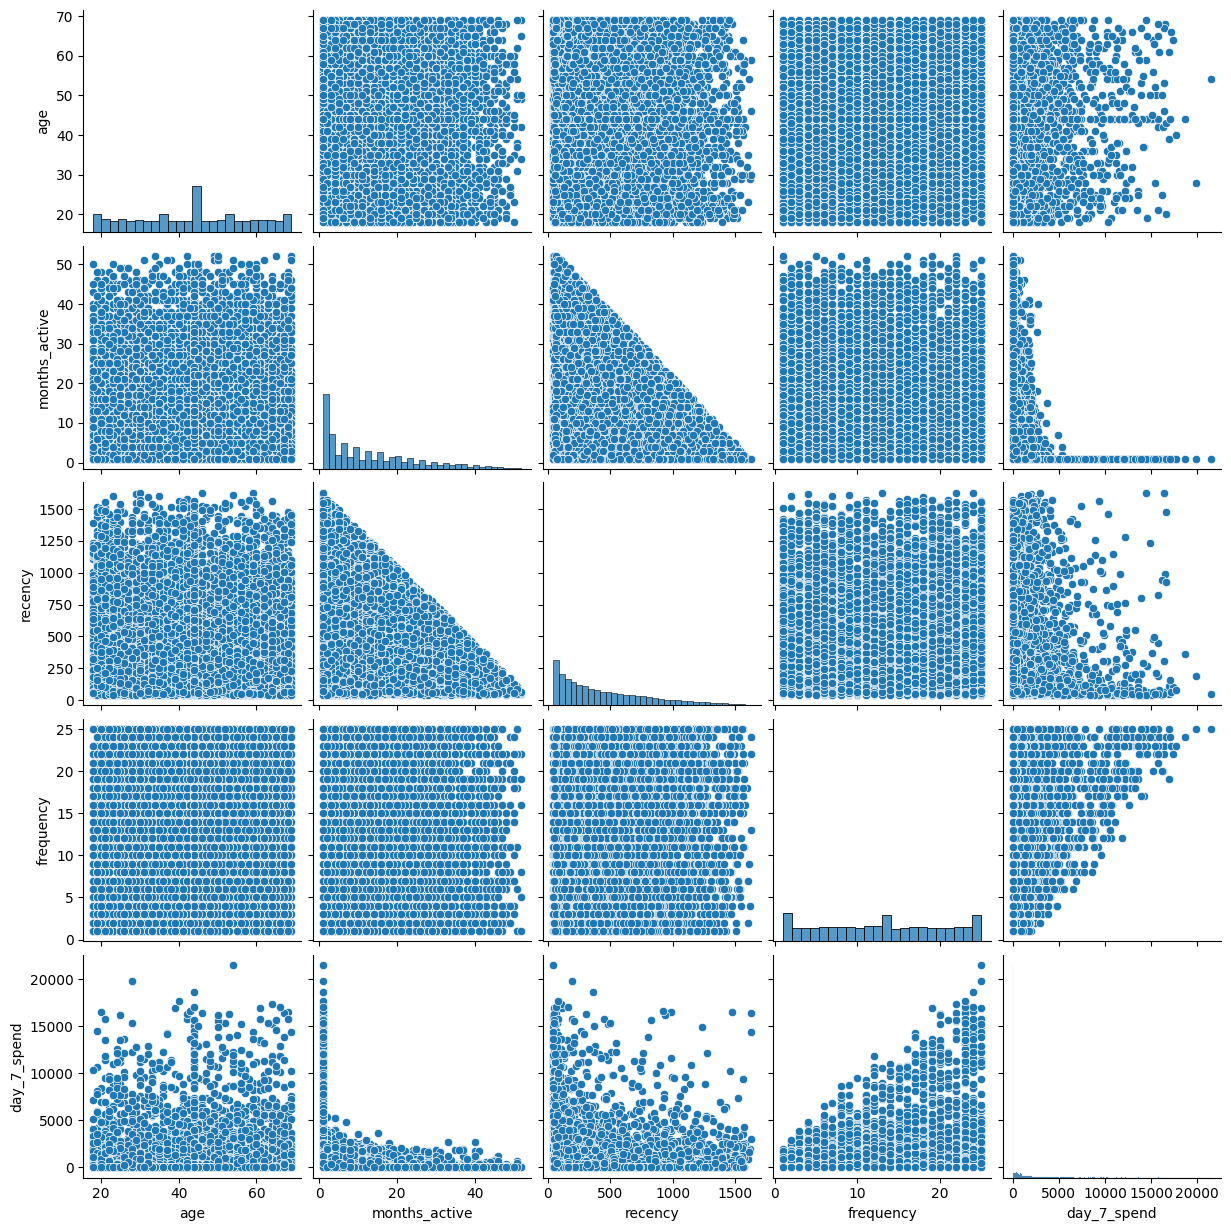

KeyError: "['number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks'] not in index"

In [9]:
# EXPLORATORY DATA ANALYSIS (EDA)

# Pairplot for initial exploration
sns.pairplot(customers[['age', 'months_active', 'recency', 'frequency', 'day_7_spend']])
plt.show()

# Correlation matrix
numeric_cols = customers[['age', 'months_active', 'recency', 'frequency', 'day_7_spend', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate']]
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Histograms for numeric columns
numeric_cols.hist(bins=15, figsize=(15, 10))
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols.columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=numeric_cols[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Handling Multicollinearity

# Feature Engineering: Create new feature based on relationship between clicks, visits, and emails
customers['click_per_visit'] = customers['click_per_transaction'] / customers['visit_per_transaction']

# Ensure there are no infinite or NaN values
customers['click_per_visit'] = customers['click_per_visit'].replace([float('inf'), -float('inf')], float('nan'))
customers['click_per_visit'].fillna(0, inplace=True)  # Replace NaN with 0 or impute

# Select features for VIF calculation
X = customers[['age', 'months_active', 'recency', 'frequency', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate', 'click_per_visit']]

# Check for remaining NaN or inf values
nan_columns = X.columns[X.isna().any()].tolist()
if nan_columns:
    print(f"Warning: NaN values found in columns: {nan_columns}")
    
inf_columns = X.columns[np.isinf(X).any()].tolist()
if inf_columns:
    print(f"Warning: Inf values found in columns: {inf_columns}")

# Handling NaN Values in 'frequency' (if still present)
customers['frequency'].fillna(0, inplace=True)

# Ensure there are no infinite values left
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)  # Replace any remaining NaN with 0 or impute as necessary

# Handling Multicollinearity

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF values:")
print(vif_data)

# Model Building and Evaluation

# Preparing data for model building
y = customers['day_7_spend']  # Use day_7_spend as the target variable

# Ensure that 'monetary' is not included in the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
lr_r2 = r2_score(y_test, lr_preds)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R²: {lr_r2}")

# Random Forest Regressor Model with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
rf_preds = best_rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R²: {rf_r2}")

# Classification Models
# Assuming binary classification problem (e.g., predicting high vs low spenders based on a threshold)
threshold = y_train.median()
y_train_class = (y_train > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

# Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_class)
log_reg_preds = log_reg.predict(X_test)
log_reg_f1 = f1_score(y_test_class, log_reg_preds)
log_reg_roc_auc = roc_auc_score(y_test_class, log_reg_preds)
print(f"Logistic Regression F1 Score: {log_reg_f1}")
print(f"Logistic Regression ROC AUC: {log_reg_roc_auc}")

# K-Nearest Neighbors Classifier Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train_class)
knn_preds = knn.predict(X_test)
knn_f1 = f1_score(y_test_class, knn_preds)
knn_roc_auc = roc_auc_score(y_test_class, knn_preds)
print(f"KNN Classifier F1 Score: {knn_f1}")
print(f"KNN Classifier ROC AUC: {knn_roc_auc}")

# Naive Bayes Classifier Model
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train_class)
nb_preds = nb.predict(X_test)
nb_f1 = f1_score(y_test_class, nb_preds)
nb_roc_auc = roc_auc_score(y_test_class, nb_preds)
print(f"Naive Bayes Classifier F1 Score: {nb_f1}")
print(f"Naive Bayes Classifier ROC AUC: {nb_roc_auc}")